In [1]:
%run init_notebook.py

In [2]:
import spacy
import regex as re

import time
from itertools import compress
from collections import Counter
from src.utils import vec_similarity, arr_min_max_scale, save_pd_df

from matplotlib.pyplot import cm

from uuid import uuid4
import pickle

In [7]:
from articles import load_pickle, DICT_NARRATIVES, load_pd_df
from src.nlp_utils import get_spacy_NLP, load_raw_data
from src.nlp_lists import LST_FREQUENT_NON_MEANING

In [8]:
NLP = get_spacy_NLP('de')

# supervised narrative topics

news data

In [9]:
dict_txts = {}
for file in [i for i in os.listdir(NEWS_TEXT_DIR) if i not in ['orig']]:
    dict_txts[file.split('.')[0]] = load_pickle(file)

len(dict_txts)

1580

In [10]:
Counter([v['is_infl'] for k, v in dict_txts.items()])

Counter({True: 1580})

ecb speeches

In [11]:
# dict_txts = {}
# for file in [i for i in os.listdir(TEXT_DIR) if i != 'orig']:
#     dict_txts[file] = load_pickle(file)

## analyse

In [13]:
'nordstream'.lower() in " ".join([v['text'] for v in dict_txts.values()])

False

In [14]:
_dict = {}
for idx, text in {k: v for k, v in dict_txts.items() if v['is_infl']}.items():
    counter = text['counter_nouns']
    for k, v in counter.items():
        if k not in LST_FREQUENT_NON_MEANING:
            if k not in _dict.keys():
                _dict[k] = v
            elif k in _dict.keys():
                _dict[k] = _dict[k] + v
c = sorted(_dict.items(), key=lambda x: x[1], reverse=True)

In [18]:
_dict['lockdowns']

66

In [15]:
c

[('inflation', 4693),
 ('preis', 2821),
 ('ezb', 2295),
 ('unternehmen', 2114),
 ('zins', 2081),
 ('usa', 1539),
 ('geld', 1448),
 ('bank', 1447),
 ('notenbank', 1426),
 ('wirtschaft', 1393),
 ('inflationsrate', 1149),
 ('europa', 1094),
 ('staat', 1071),
 ('markt', 1069),
 ('aktie', 1051),
 ('mensch', 1048),
 ('dollar', 1035),
 ('zentralbank', 952),
 ('ökonom', 947),
 ('regierung', 926),
 ('geldpolitik', 915),
 ('wert', 871),
 ('fed', 860),
 ('problem', 850),
 ('anleihe', 824),
 ('folge', 797),
 ('rendite', 765),
 ('welt', 753),
 ('china', 728),
 ('energie', 710),
 ('anleger', 698),
 ('gold', 689),
 ('nachfrage', 674),
 ('risiko', 673),
 ('kosten', 673),
 ('krise', 672),
 ('rezession', 670),
 ('grund', 662),
 ('wachstum', 662),
 ('zinserhöhung', 659),
 ('pandemie', 631),
 ('investor', 619),
 ('anstieg', 595),
 ('lohn', 595),
 ('kurs', 575),
 ('kerninflation', 567),
 ('kunde', 560),
 ('leitzins', 555),
 ('fall', 547),
 ('energiepreis', 537),
 ('märz', 525),
 ('politik', 516),
 ('schuld

In [11]:
NLP('gas')[0].similarity(NLP('erdgas')[0])

0.5730186104774475

In [12]:
# [i for i in c if 'pipeline' in i[0]]
# c[100:200]

In [13]:
# from scratch

In [14]:
# lst_docs = [NLP(i['text']) for i in list(dict_txts.values())]

# doc = lst_docs[0]

# for noun_phrase in list(doc.noun_chunks):
#     noun_phrase.merge(noun_phrase.root.tag_, noun_phrase.root.lemma_, noun_phrase.root.ent_type_)

In [15]:
# [" ".join([lst_docs[0][i-1].lemma_.lower(), lst_docs[0][i].lemma_.lower()]) for i in range(1, len(lst_docs[0])-1)]

In [16]:
# x = [*lst_docs[0].noun_chunks][1

In [17]:
# lst_nouns = [
#     [
#         i for i in doc if 
#         (
#             i.is_alpha
#             and 
#             (
#                 i.pos_ in ['NOUN', 'PROPN', 'ADJ']
#                 # and i.ent_type_ == ""
#             )
#             and not (i.is_stop or i.is_punct or i.is_currency or i.is_bracket)
#             and i.lemma_.lower() not in LST_FREQUENT_NON_MEANING
#         )
#     ] for doc in lst_docs
# ]

# c = sorted(Counter([i.lemma_.lower() for i in [*chain(*lst_nouns)]]).items(), key=lambda x: x[1], reverse=True)

In [18]:
# sorted(_dict.items(), key=lambda x: x[1], reverse=True)

# narrative scores

In [36]:
df = pd.DataFrame(
    {
        (dkey, doc['date']) : {
            nkey: narrative['narrative_score_det'] for nkey, narrative in doc['narratives'].items()
        } for dkey, doc in dict_txts.items()
    }
).T.sort_index()
df = df.reset_index(names=['id', 'date'])

In [37]:
df_g = df.drop('id', axis=1).groupby('date').sum().copy()
df_g.iloc[:, : ] = df_g.values / df.groupby('date').id.count().values[:,None]
df_g = df_g.rolling(15).mean()


In [32]:
df_g2 = df.drop('id', axis=1).groupby('date').sum().copy() #/ df.groupby('date').id.count()
df_g2.iloc[:, : ] = df_g2.values / df.groupby('date').id.count().values[:,None]
# df_g2 = df_g2.rolling(15).mean()


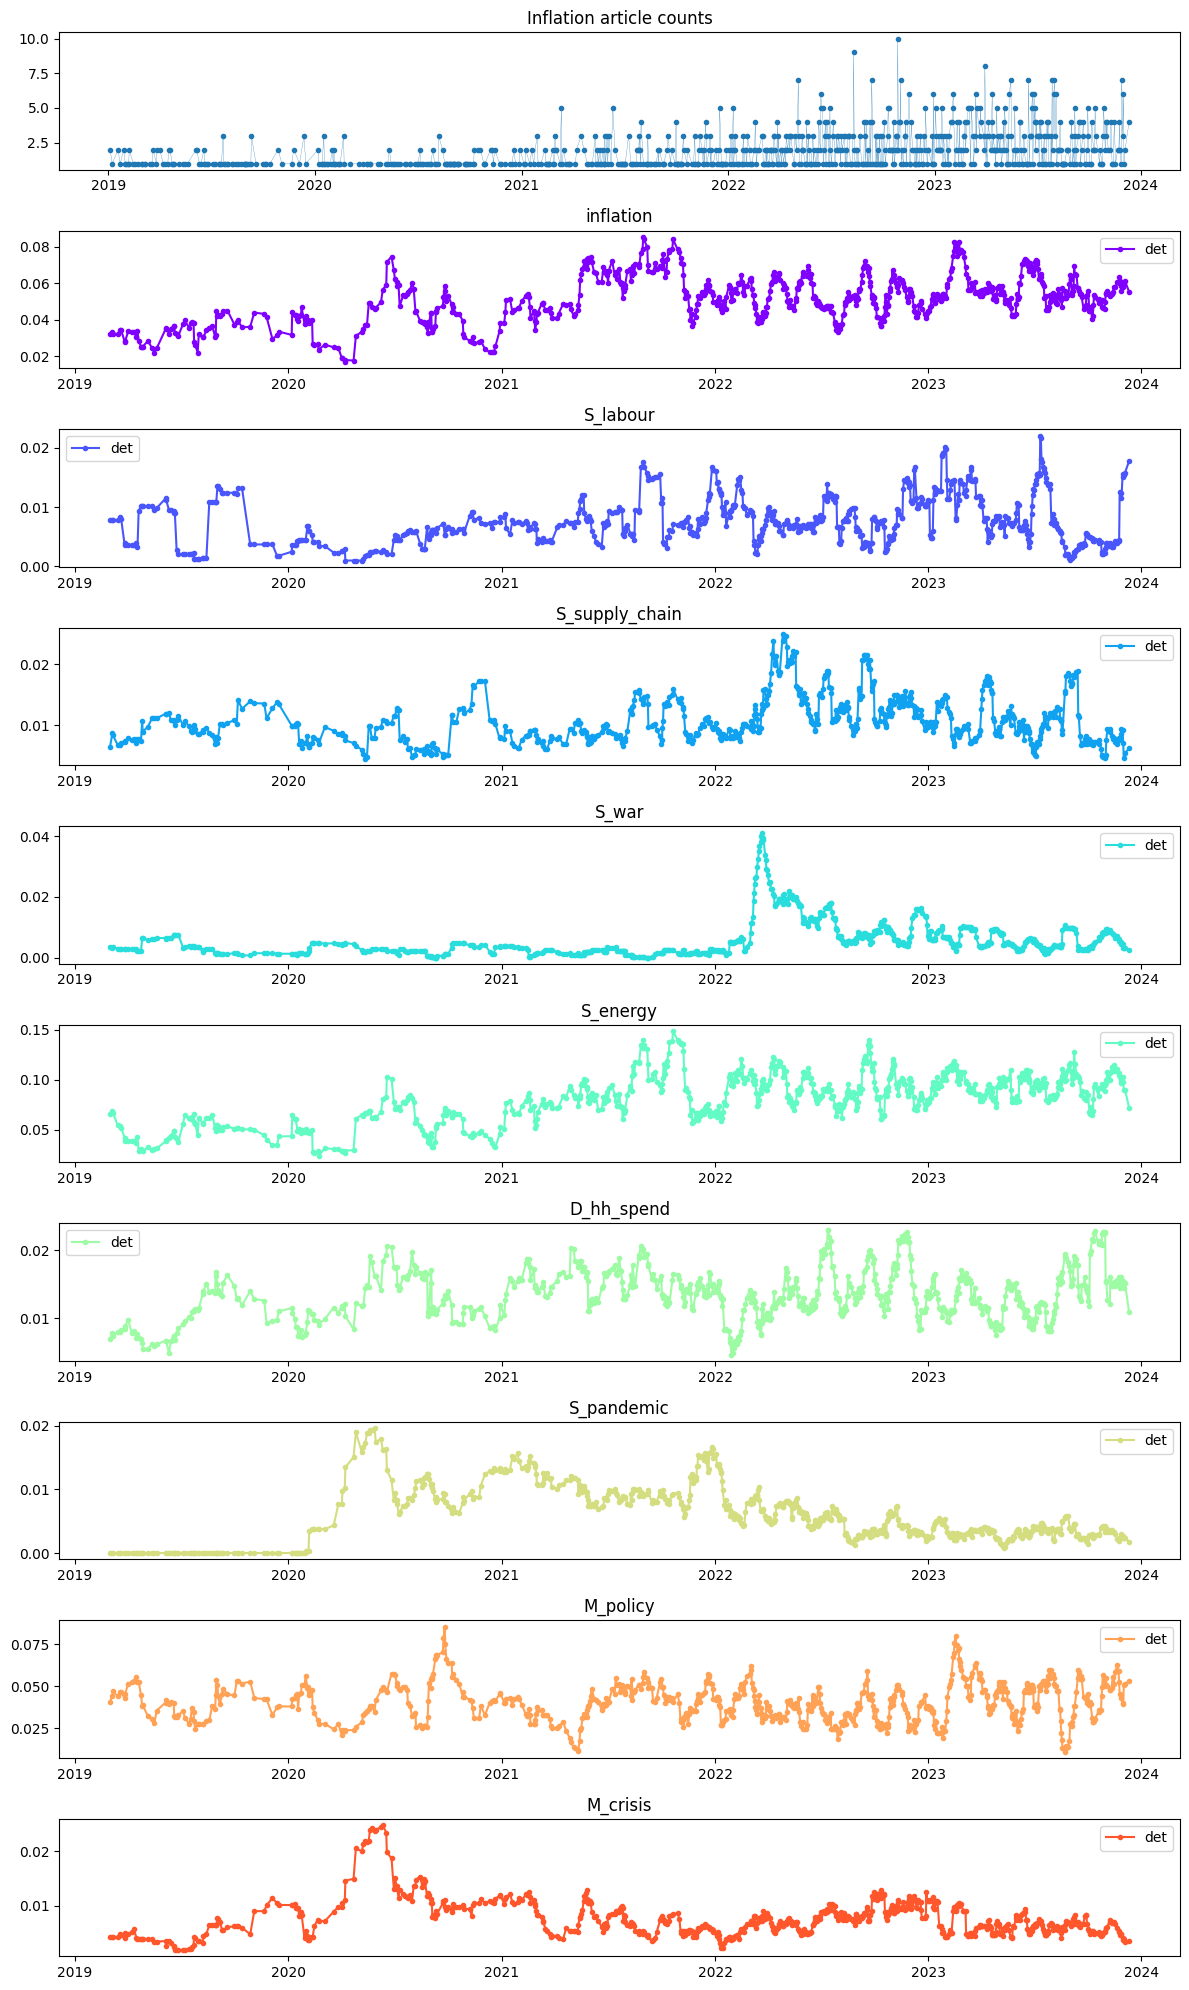

In [38]:
nrows = df_g.shape[1] + 1
fig, axes = plt.subplots(nrows, 1, figsize=(12, 2 * nrows))
color = cm.rainbow(np.linspace(0, 1, nrows))

axes.ravel()[0].plot(df.groupby('date').id.count(), lw=0.2, marker='.')
axes.ravel()[0].set_title('Inflation article counts')
for i, ax in enumerate(axes.ravel()[1:]):
    ax.plot(df_g.iloc[:, i], c=color[i], marker='.', )
    # ax.twinx().plot(df_g2.iloc[:, i], c='black', marker='.',)
    ax.set_title(label=df_g.columns[i])
    ax.legend(['det', 'sim'])
            
    
plt.tight_layout()

In [39]:
save_pd_df(df, "det_topics.feather")